Project to recognize facial expressions using CNN networks

First we get the data. I have uploaded the train and test csv files on my drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!ls '/content/drive/My Drive/My projects/data/fer'

# Data is in the form [ label ,string of pixels]


train.csv


Import the required libraries

In [21]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as Transforms
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset

We define the necessary transforms for augmenting the data and getting a higher accuracy.

In [4]:
train_transform = Transforms. Compose([
                                      
                                      Transforms.RandomHorizontalFlip(),
                                    
                                      Transforms.RandomCrop(44),
                                      Transforms.Normalize((0.5),(0.5))
])
test_transform = Transforms.Compose([
                                     Transforms.Resize(44),
                                    Transforms.Normalize((0.5),(0.5),
                                    
                                    )
])

We store the csv file path for easier access


In [5]:
fer_csv = '/content/drive/My Drive/My projects/data/fer/train.csv'

Now we split the data into train data and test data

In [6]:
full_df = pd.read_csv(fer_csv)
train_df = full_df.sample(frac = 0.870807064)  # This fraction used so that we get our train data to be exactly 25000
test_df = full_df.drop(train_df.index)
print(train_df.shape)
print(test_df.shape)

train_df.to_csv('train.csv' , index = False)
test_df.to_csv('test.csv', index = False)
train_csv = 'train.csv'
test_csv = 'test.csv'

(25000, 2)
(3709, 2)


Let us define the class FERDataset for our train and test datasets.

In [7]:
class FERDataset(Dataset):
    
    def __init__(self, file_path, transform=None ):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        #print(self.data.head())




    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = self.data.iloc[index, 1]
        #img = img.split('"')
        #img = img[1]
        img = img.split(" ") # because the pixels are seperated by space
        img = np.array(img, 'int') # just make sure it is int not str
        img = img.reshape(1,48,48)
        #img = np.transpose(img, (1,2,0))
        #img = Image.fromarray((img * 255).astype(np.uint8))

        img = torch.tensor(img)
        img = torch.reshape(img,(1,48,48))
        img = img.type(torch.FloatTensor)
        label = self.data.iloc[index, 0]
       
        if self.transform is not None:
            img = self.transform(img)
            
        return img, label

Define some hyper parameters

In [8]:
classes = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')
batch_size = 64
num_of_epochs = 50

Now let us  apply transforms and load the data using data loader

In [9]:
#FER_Dataset = FERDataset(file_path = fer_csv, transform = test_transform)
train_data = FERDataset(file_path = train_csv, transform = train_transform)
test_data = FERDataset(file_path = test_csv, transform = test_transform)
train_loader = torch.utils.data.DataLoader(dataset = train_data, shuffle = True , batch_size = batch_size )
test_loader = torch.utils.data.DataLoader(dataset = test_data, shuffle = False , batch_size = batch_size  )

In [10]:
train_iter = iter(train_loader)
images,labels = train_iter.next()
print(len(train_data))
print(images.shape)
print(labels.shape)
images = images.type(torch.LongTensor)
labels = labels.type(torch.LongTensor)
#print(images[0].shape)

25000
torch.Size([64, 1, 44, 44])
torch.Size([64])


Now let us print the first few images of our dataset. First we need to reshape the images to (48,48,1) 

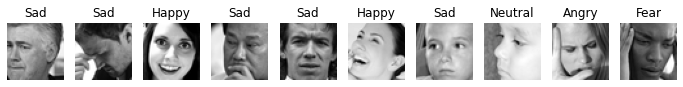

In [11]:
fig,axs = plt.subplots(nrows = 1 , ncols= 10 , figsize = (12,12))

for img,i in zip(images,range(10)):
  np_img = img.numpy()
  np_img = np.reshape(np_img,(44,44))
  axs[i].imshow(np_img, cmap = 'gray')
  axs[i].axis('off')
  axs[i].set_title(classes[labels[i]])
plt.show()  

Now we define our model. I have tested two different models. 
1) A custom model
2) VGG-13

In [12]:
# Custom
class Net(nn.Module):
  def __init__(self):
     super(Net,self).__init__()
     self.conv1 = nn.Conv2d(in_channels= 1 , out_channels= 16, kernel_size= (3,3), stride=1)
     self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 64 , kernel_size= (3,3),stride = 1)
     self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128 , kernel_size= (3,3),stride = 1)
     self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256 , kernel_size= (3,3),stride = 1)
     self.maxpool = nn.MaxPool2d(kernel_size = (2,2) , stride = 2, ceil_mode=True)
     self.fc1 = nn.Linear(in_features = 1*1*256 , out_features = 120)
     self.fc2 = nn.Linear(in_features = 120 , out_features = 84)
     self.fc3 = nn.Linear(in_features = 84 , out_features = 7)
     self.dropout = nn.Dropout(0.5)
     self.batchnorm1 = nn.BatchNorm2d(16)
     self.relu = nn.ReLU()
     self.batchnorm2 = nn.BatchNorm2d(128)
     self.batchnorm3 = nn.BatchNorm2d(120)
     self.batchnorm4 = nn.BatchNorm2d(84)

  def forward(self,x):
    x = torch.tensor(x,dtype=self.conv1.weight.dtype)
    x = F.relu(self.conv1(x))
    x = self.batchnorm1(x)
    x = self.maxpool(x)
    x = self.maxpool(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = self.batchnorm2(x)
    x = self.maxpool(x)
    x = self.maxpool(F.relu(self.conv4(x)))
    x = x.view(-1,1*1*256)
    x = F.relu(self.fc1(x))
  #  x = self.batchnorm3(x)
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
   # x = self.batchnorm4(x)
    x = self.dropout(x)
    x = self.fc3(x)
    return x
     

model = Net()
y = model(images)
print(y.shape)


torch.Size([64, 7])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [13]:
'''
#VGG16

VGG_types = {
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG16": [64,64, "M",128,128,"M",256,256,256,"M",512,512,512,"M",512,512,512,"M",],
    "VGG19": [64,64,"M",128,128,"M",256,256,256,256,"M",512,512,512,512,"M",512,512,512,512,"M", ],
}


class VGG_net(nn.Module):
    def __init__(self, in_channels=1, num_classes=7):
        super(VGG_net, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG_types["VGG11"])
        self.conv1 = nn.Conv2d(1,1,1)
        self.fcs = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
       # y = self.conv1.weight.dtype
        x = torch.tensor(x,dtype= torch.float32)
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fcs(x)
        return x

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x

                layers += [
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=(3, 3),
                        stride=(1, 1),
                        padding=(1, 1),
                    ),
                    nn.BatchNorm2d(x),
                    nn.ReLU(),
                ]
                in_channels = x
            elif x == "M":
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2) , ceil_mode=  True)]

        return nn.Sequential(*layers)



model = VGG_net(in_channels=1, num_classes=7)  
y = model(images)
print(y.shape)
'''

'\n#VGG16\n\nVGG_types = {\n    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],\n    "VGG13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],\n    "VGG16": [64,64, "M",128,128,"M",256,256,256,"M",512,512,512,"M",512,512,512,"M",],\n    "VGG19": [64,64,"M",128,128,"M",256,256,256,256,"M",512,512,512,512,"M",512,512,512,512,"M", ],\n}\n\n\nclass VGG_net(nn.Module):\n    def __init__(self, in_channels=1, num_classes=7):\n        super(VGG_net, self).__init__()\n        self.in_channels = in_channels\n        self.conv_layers = self.create_conv_layers(VGG_types["VGG11"])\n        self.conv1 = nn.Conv2d(1,1,1)\n        self.fcs = nn.Sequential(\n            nn.Linear(512 * 7 * 7, 4096),\n            nn.ReLU(),\n            nn.Dropout(p=0.5),\n            nn.Linear(4096, 4096),\n            nn.ReLU(),\n            nn.Dropout(p=0.5),\n            nn.Linear(4096, num_classes),\n        )\n\n    def forward(self, x):\n       # y = self.conv1

Now we will define our loss funciton and optimizer

In [14]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=5e-4)

We will initialize some lists that will help us plot our graphs

In [15]:
train_loss_list = []
train_accuracy_list = []
test_loss_list=[]
test_accuracy_list = []


Now we will define our training loop

In [16]:
for epoch in range(num_of_epochs):

  train_loss = 0
  test_loss = 0
  total_trained = 0
  correct_trained = 0
  train_accuracy = 0
  total_tested = 0
  correct_tested = 0
  test_accuracy = 0 

  for image,label in train_loader:
   
   
   #forward pass
   train_pred = model(image)
   #calculating the loss
   loss = criteria(train_pred,label)
   #backward pass
   loss.backward()
   #changing weights
   optimizer.step()

   #emptying the gradient 
   optimizer.zero_grad()
   
   #now lets find the train accuracy and the train loss
   train_loss+= loss.item()

   _,train_pred = torch.max(train_pred,1)
   total_trained += label.size(0)
   correct_trained += train_pred.eq(label).sum().item()
 
   #displaying the loss for each epoch
  train_loss/= len(train_loader)
  train_accuracy = 100.*(correct_trained/total_trained)
  print(f'Epoch: {epoch+1} , Train Loss: {train_loss} , Train Accuracy: {train_accuracy}' ,  )
  
  
  

   #End of training

   #Now the test loop

  with torch.no_grad():  #we dont want to change our gradient when we test our data
     for image,label in (test_loader):
       
       test_pred = model(image)

       loss = criteria(test_pred,label)
       
       #now lets find the train accuracy and the Train loss
       
       test_loss+= loss.item()

       #  The shape of test_pred is (50,10) i.e. it has a classification score for each of the 10 categories.
       # The image belongs to the category with the maximum score.
       # We also need to then transform the tensor into a 1D tensor with shape (50) and the data must be the category.

      
       _,test_pred = torch.max(test_pred,1)
       total_tested += label.size(0)
       correct_tested += test_pred.eq(label).sum().item()
       

     # Displaying the loss for each epoch
     test_loss/= len(test_loader)
     test_accuracy = 100.*(correct_tested/total_tested)
     print(f'Epoch: {epoch+1} , Test Loss: {test_loss} , Test Accuracy: {test_accuracy}' ,  )
    
    #updating our lists

     train_loss_list.append(train_loss)
     test_loss_list.append(test_loss)
     train_accuracy_list.append(train_accuracy)
     test_accuracy_list.append(test_accuracy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 1 , Train Loss: 1.6782486938759493 , Train Accuracy: 32.556000000000004
Epoch: 1 , Test Loss: 1.5676496131666775 , Test Accuracy: 39.201941224049605
Epoch: 2 , Train Loss: 1.4357662798498598 , Train Accuracy: 45.192
Epoch: 2 , Test Loss: 1.3920658765168026 , Test Accuracy: 47.452143434888114
Epoch: 3 , Train Loss: 1.3305425474710781 , Train Accuracy: 49.632
Epoch: 3 , Test Loss: 1.367907162370353 , Test Accuracy: 48.74629280129415
Epoch: 4 , Train Loss: 1.2817695095106159 , Train Accuracy: 52.38
Epoch: 4 , Test Loss: 1.3263994393677547 , Test Accuracy: 50.57967107036937
Epoch: 5 , Train Loss: 1.2440417044607879 , Train Accuracy: 53.848
Epoch: 5 , Test Loss: 1.2811338377409969 , Test Accuracy: 51.92774332704233
Epoch: 6 , Train Loss: 1.2002054158683932 , Train Accuracy: 55.456
Epoch: 6 , Test Loss: 1.2576937274686222 , Test Accuracy: 52.52089511997843
Epoch: 7 , Train Loss: 1.1843113115681407 , Train Accuracy: 56.147999999999996
Epoch: 7 , Test Loss: 1.2523589329472904 , Test Acc

Now, we will plot the loss graph and the accuracy graph

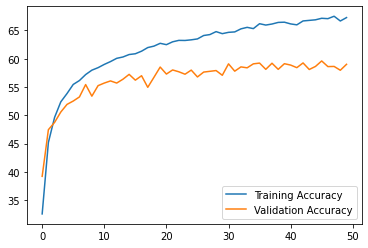

In [17]:
#accuracy graph
plt.plot(train_accuracy_list, label ='Training Accuracy')
plt.plot(test_accuracy_list, label = 'Validation Accuracy')
plt.legend()

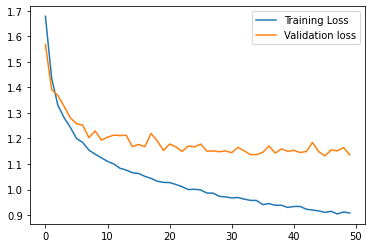

In [18]:
#loss graph
plt.plot(train_loss_list, label ='Training Loss')
plt.plot(test_loss_list, label = 'Validation loss')
plt.legend()